## Training DenseNet121 with landmark images

In [1]:
# imports
import datetime
import time
import os
import random
import re
import tempfile
import warnings
import pandas as pd
import torch
from torch.utils.data import DataLoader
from dataio.dataset import ImageLabels
from dataio.data_sampler import RandomOverSampler
from networks.densenet_classifier import densenet121_classifier
from training.evaluation import AccuracyEvaluator, LossEvaluator
from training.utility.progress_bar import ProgressBar
from training.utility.early_stopper import ValLoss as EarlyStopper
from training.utility.signal_control import SignalFileControl


# whenever possible, use cuda instead of cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    warnings.warn("torch is using CPU, as cuda is unavailable. this is inefficient.")
torch.set_default_device(device)

# setting random state
random.seed(233)
_ = torch.manual_seed(233)

# whenever possible, use cuda instead of cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    warnings.warn("torch is using CPU, as cuda is unavailable. this is inefficient.")
torch.set_default_device(device)

# paths to save and load state dictionary
load_sd = True
save_sd = True

bin_path = os.path.abspath("bin")
assert os.path.isdir(bin_path)

# if load_sd set True, load from state dict
sd_load_path = None
starting_epoch = 0
sd_file_pattern = r'densenet121_landmark_state_[0-9]{2}-[0-9]{2}-ep_[0-9]{2}\.pkl'
sd_epoch_pattern = r'densenet121_landmark_state_[0-9]{2}-[0-9]{2}-ep_([0-9]{2})\.pkl'
if load_sd:
    sd_files = [
        filename for filename in os.listdir(bin_path)
        if re.match(sd_file_pattern, filename)]
    sd_files.sort(reverse=True)
    if len(sd_files) > 0:
        sd_filename = sd_files[0]
        sd_load_path = os.path.join(bin_path, sd_filename) \
            if sd_filename is not None else None
        match = re.search(sd_epoch_pattern, sd_filename)
        starting_epoch = int(match.group(1))
        print(f'- loaded state from: {sd_filename}')
print(f"- starting from epoch: {starting_epoch + 1}")

# tempfile to save the model every time it reaches the best validation loss
state_dict_backup_path = tempfile.mktemp(prefix='state-dict_', suffix='.pth')

- loaded state from: densenet121_landmark_state_06-07-ep_22.pkl
- starting from epoch: 23


read data from the table, split into training, validation and test sets by patient id

In [2]:
# load the image quality table
image_quality_table_path = r"D:\data\cochlear-project\tables\landmark_image_quality.csv"
image_quality_table = pd.read_csv(image_quality_table_path)
# separation of training, validation and test sets
patient_ids = image_quality_table['patient_id'].unique().tolist()
total_count = len(patient_ids)
validation_size = 0.15
test_size = 0.1
validation_count = round(total_count * validation_size)
test_count = round(total_count * test_size)
training_count = total_count - validation_count - test_count
random.shuffle(patient_ids)
training_ids = patient_ids[:training_count]
validation_ids = patient_ids[training_count:training_count+validation_count]
test_ids = patient_ids[training_count+validation_count:]
training_table = image_quality_table[image_quality_table['patient_id'].isin(training_ids)]
validation_table = image_quality_table[image_quality_table['patient_id'].isin(validation_ids)]
test_table = image_quality_table[image_quality_table['patient_id'].isin(test_ids)]
# showing image counts and distribution of labels in 3 sets
print(f"training: {training_table.shape[0]} images\n{training_table['label'].value_counts()}")
print(f"validation: {validation_table.shape[0]} images\n{validation_table['label'].value_counts()}")
print(f"test: {test_table.shape[0]} images\n{test_table['label'].value_counts()}")

training: 217 images
label
2    101
1     95
3     21
Name: count, dtype: int64
validation: 60 images
label
2    39
1    11
3    10
Name: count, dtype: int64
test: 17 images
label
2    12
1     4
3     1
Name: count, dtype: int64


create corresponding datasets and dataloaders

In [3]:
num_workers = 16
batch_size = 4
# create training, validation and test sets
training_dataset = ImageLabels.from_iterables(training_table['image_path'], training_table['label'], augmentation=True)
validation_dataset = ImageLabels.from_iterables(validation_table['image_path'], validation_table['label'])
test_dataset = ImageLabels.from_iterables(test_table['image_path'], test_table['label'])
# oversample on training datasets
training_sampler = RandomOverSampler(training_table['label'].tolist(), max_duplicates=2)
# define dataloaders
training_dataloader = DataLoader(training_dataset, batch_size, num_workers=num_workers, sampler=training_sampler)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=num_workers, pin_memory=True)
test_dataloader = DataLoader(validation_dataset, batch_size, num_workers=num_workers)

model and training configurations

In [4]:
# training configurations
learning_rate = 0.00005 # 0.001 # 0.00005, originally without lr scheduler
n_epoches = 7
min_epoches = 3 # minimum epoches before early stopper allowed

# the classifier model
model = densenet121_classifier.to(device=device)
model.drop_rate = 0.2

# optimizers
# loss_function = torch.nn.CrossEntropyLoss() # (weight=torch.Tensor([0.1, 0.45, 0.45]).to(device))
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=3, gamma=0.25
)

# accuracy and loss evaluators
training_loss_evaluator = LossEvaluator(loss_function)
validation_loss_evaluator = LossEvaluator(loss_function)
validation_accuracy = AccuracyEvaluator()

best_epoch, best_loss = None, None
first_run = True

training_losses = []
validation_losses = []

(below for continued learning only)

In [14]:
if not first_run:
    learning_rate = 0.000025
    n_epoches = 13

start training

In [5]:
earlystopper = EarlyStopper(tolerance=3, target=0.1, cooldown=1)
signalstopper = SignalFileControl()

# training epoches loop
for epoch in range(n_epoches):
    current_epoch = epoch + 1 + starting_epoch
    print(f'epoch # {current_epoch}')
    progress = ProgressBar(len(training_dataloader) + len(validation_dataloader))
    epoch_start_time = time.time()
    # reset pred and actual labels after each epoch
    validation_accuracy.reset()
    training_loss_evaluator.reset()
    validation_loss_evaluator.reset()
    
    # training network
    model.train()
    for images, labels in training_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_pred = model(images)
        # train loss
        training_loss = loss_function(labels_pred, labels)
        # backpropagation
        optimizer.zero_grad()
        # training_loss.requires_grad = True
        training_loss.backward()
        optimizer.step()
        progress.step()
        training_loss_evaluator.append_loss(training_loss.item())

    
    # validating network
    model.eval()
    for images, labels in validation_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_pred = model(images)
        validation_loss = loss_function(labels_pred, labels)
        validation_accuracy.append(labels_pred, labels)
        progress.step()
        validation_loss_evaluator.append_loss(validation_loss.item())
    epoch_end_time = time.time()
    # step scheduler
    scheduler.step() # (validation_loss_evaluator.value())
    print(
        f'train loss: {training_loss_evaluator}  \
        validation loss: {validation_loss_evaluator}  \
        validation accuracy: {validation_accuracy}')
    print(
        f'precision: {round(validation_accuracy.precision(), 3)}  \
        recall: {round(validation_accuracy.recall(), 3)}  \
        f1: {round(validation_accuracy.f1(), 3)}')
    # the evaluators have __str__
    print(
        f'duration: {round(epoch_end_time - epoch_start_time, 2)} s  \
        learning rate: {round(scheduler.get_last_lr()[0], 9)}')
    
    # if reaching best validation loss, back up the state
    if validation_loss_evaluator.is_best():
        best_epoch = current_epoch
        best_loss = validation_loss_evaluator.value()
        if save_sd and current_epoch > 1:
            # remove existing tempfile if exists
            os.remove(state_dict_backup_path) if os.path.isfile(state_dict_backup_path) else None
            torch.save(model.state_dict(), state_dict_backup_path)

    training_losses.append(training_loss_evaluator.value())
    validation_losses.append(validation_loss_evaluator.value())

    # step early stopper
    earlystopper.step(validation_loss_evaluator.value())
    print('-'*75)
    if earlystopper.stop() and epoch >= min_epoches:
        print('early stopper triggered, break')
        break
    if signalstopper.stop():
        print('signalled stop')
        break

signalstopper.reset()
# update the starting epoch number
starting_epoch = current_epoch
first_run = False
print('-' * 75)
# show the best epoch, and save, if there is any
if best_epoch is not None:
    print(f'best validation loss: {round(best_loss, 5)}, epoch {best_epoch}')
    print(f'saved to temp file: {state_dict_backup_path}')
    
else:
    print(f'validation loss does not improve')

signal file path: C:\Users\user\AppData\Local\Temp\signal-06-08-h3t81gxz
epoch # 23
train loss: 0.553          validation loss: 0.492          validation accuracy: 58.33 %
precision: 0.86          recall: 1.0          f1: 0.925
duration: 42.62 s          learning rate: 5e-05
---------------------------------------------------------------------------
epoch # 24
train loss: 0.342          validation loss: 0.351          validation accuracy: 75.0 %
precision: 0.889          recall: 0.98          f1: 0.932
duration: 46.91 s          learning rate: 5e-05
---------------------------------------------------------------------------
epoch # 25
train loss: 0.227          validation loss: 0.265          validation accuracy: 86.67 %
precision: 0.922          recall: 0.959          f1: 0.94
duration: 66.76 s          learning rate: 1.25e-05
---------------------------------------------------------------------------
epoch # 26
train loss: 0.153          validation loss: 0.241          validation acc

save state dict if having improvements

In [7]:
if best_epoch is not None:
    sd_save_filename = f"densenet121_landmark_state_{datetime.datetime.now().strftime('%m-%d')}-ep_{current_epoch}.pkl"
    sd_save_path = os.path.join(bin_path, sd_save_filename)
    torch.save(model.state_dict(), sd_save_path)
    print(f'state dict saved to path: {sd_save_path}')

state dict saved to path: g:\My Drive\master_courses\BIDH5001 Capstone\Project\deep-classification\bin\densenet121_landmark_state_06-07-ep_7.pkl


running on test set

In [8]:
test_loss_evaluator = LossEvaluator(criterion=loss_function)
test_accuracy_evaluator = AccuracyEvaluator()
saliency_image = None

for images, labels in test_dataloader:
    images = images.to(device=device)
    labels = labels.to(device=device)
    labels_pred = model(images)
    test_loss = loss_function(labels_pred, labels)
    test_loss_evaluator.append_loss(test_loss)
    test_accuracy_evaluator.append(labels_pred, labels)
    # obtain a saliency image with good image quality
    if saliency_image is None and torch.argmax(labels[0]).item() == 2:
        saliency_image = images
print(f'test loss: {test_loss_evaluator}\
    test accuracy: {test_accuracy_evaluator}')
print(
    f'precision: {round(test_accuracy_evaluator.precision(), 2)}  \
    recall: {round(test_accuracy_evaluator.recall(), 2)}  \
    f1: {round(test_accuracy_evaluator.f1(), 2)}')

test loss: 0.281    test accuracy: 85.0 %
precision: 0.98      recall: 0.88      f1: 0.92


Visualization of Results

In [7]:
# visualization imports
import matplotlib.pyplot as plt
from sklearn import metrics

plots showing improvements in training and validation loss

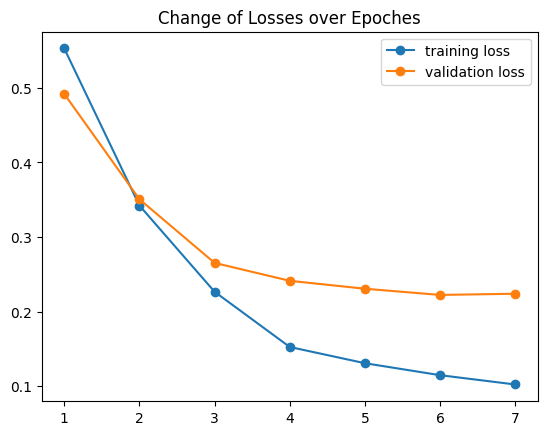

In [8]:
training_loss_history = training_losses # training_loss_evaluator.history
validation_loss_history = validation_losses # validation_loss_evaluator.history
# assert len(training_loss_history) == len(validation_loss_history)
plt.plot([i+1 for i in range(len(training_loss_history))], training_loss_history, '-o', label='training loss')
plt.plot([i+1 for i in range(len(validation_loss_history))], validation_loss_history, '-o', label='validation loss')
plt.title('Change of Losses over Epoches')
plt.legend()
plt.show()


In [11]:
current_epoch

7

confusion matrix of prediction values

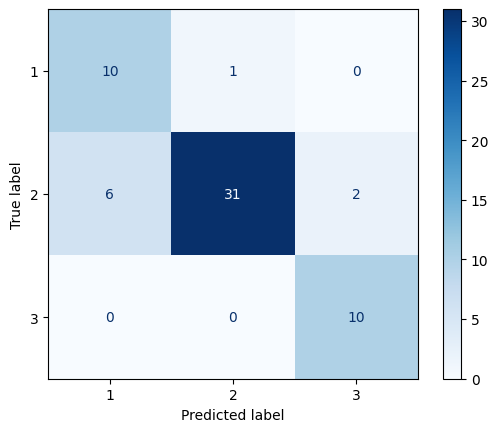

In [12]:
labels_actual = validation_accuracy.labels_actual
labels_pred = validation_accuracy.labels_pred
cm_dict = {actual: {pred: 0 for pred in (1,2,3)} for actual in (1,2,3)}
for label_actual, label_pred in zip(labels_actual, labels_pred):
    cm_dict[label_actual][label_pred] += 1
confusion_matrix = metrics.confusion_matrix(labels_actual, labels_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

plot original image and saliency map of the model

In [13]:
_, axs = plt.subplots(nrows=1, ncols=2)
for _ in zip()

if saliency_image.shape[0] > 1:
    saliency_image = saliency_image[[0]]
saliency_image.requires_grad_()
saliency_label_pred = model(saliency_image)
saliency_label_actual = torch.Tensor([[0, 0, 1]]).to(device)
saliency_loss = loss_function(saliency_label_pred, saliency_label_actual)
saliency_loss.backward()
# _, saliency_map = torch.max(saliency_image.grad.data.abs(), dim=1)
saliency_map = saliency_image.grad.data.abs()[0][0]
_, axs = plt.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].imshow(saliency_image.to('cpu')[0][0].detach().numpy(), 'binary_r')
axs[1].imshow(saliency_map.to('cpu').detach().numpy(), plt.cm.hot)
plt.title()
plt.show()

SyntaxError: expected ':' (4083414561.py, line 2)